In [1]:
from rostering_solver import Instance, Solver
import pandas as pd
import numpy as np
import json
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
city = 'berlin'
demand_baseline = "1.00"
demand_type = "doublepeak" # "fixed" demand_type
outsourcing_cost_multiplier = 1.5
model = "flex" # "fixed" # "flex"

read_instance_file = False

In [3]:
if read_instance_file:
    demand_file = f'{city}_db={demand_baseline}_dt={demand_type}.csv'
    print(demand_file)

    demand_df = pd.read_csv(demand_file, index_col=0)
    demand_df['area_id'] = demand_df['area_id'].astype(str) 
    days_ = []
    for i in range(7):
        days_.append([i, "1.00", "uniform"])
    days = pd.DataFrame(days_, columns=['day', 'demand_baseline', 'demand_type']) 
else:
    # Generate instance file
    # Generate several days instances 
    days = pd.DataFrame([
        [0, demand_baseline, demand_type], # Monday
        [1, demand_baseline, demand_type], # Tuesday
        [2, demand_baseline, demand_type], # Wednesday
        [3, demand_baseline, demand_type], # Thursday
        [4, demand_baseline, demand_type], # Friday
        [5, demand_baseline, demand_type], # Satuday
        [6, demand_baseline, demand_type], # Sunday
    ], columns=['day', 'demand_baseline', 'demand_type']
    )

    demand = []
    area_region_map = None

    for i, row in days.iterrows():
        demand_baseline, demand_type = row['demand_baseline'], row['demand_type']
        key = f'{city}_db={demand_baseline}_dt={demand_type}'

        instance_file = f'../instances/{city}_db={demand_baseline}_dt={demand_type}.json'
        with open(instance_file, 'r') as file:
            instance_data = json.load(file)

        if area_region_map is None:
            regions = instance_data['geography']['city']['regions']
            area_region_map = {}
            for region in regions:
                areas = region['areas'] 
                for area in areas:
                    area_region_map[area['id']] = region['id']
        
        scenario = random.randint(0, instance_data['num_scenarios']-1)
        data_ = (
            pd.DataFrame(instance_data['scenarios'][scenario]['data'])
            .assign(
                day = row['day']
            )
        )
        demand.append(data_)

    demand_df = pd.concat(demand)
    # Add region
    demand_df['region_id'] = demand_df['area_id'].map(area_region_map)

    demand_df = demand_df[['day', 'region_id', 'area_id', 'demand', 'required_couriers']]
    #demand_df.to_csv(f'{city}_db={demand_baseline}_dt={demand_type}.csv')

display(demand_df.head(10))

,day,region_id,area_id,demand,required_couriers
0,0,1,10115,"[1, 0, 3, 5, 4, 2, 1, 0]","[1, 0, 1, 1, 1, 1, 1, 0]"
1,0,1,10117,"[1, 1, 1, 3, 2, 3, 1, 0]","[1, 1, 1, 1, 1, 1, 1, 0]"
2,0,1,10119,"[0, 2, 5, 0, 3, 3, 1, 0]","[0, 1, 1, 0, 1, 1, 1, 0]"
3,0,1,10178,"[0, 1, 3, 2, 1, 4, 1, 0]","[0, 1, 1, 1, 1, 1, 1, 0]"
4,0,1,10179,"[0, 5, 3, 4, 5, 2, 3, 0]","[0, 1, 1, 1, 1, 1, 1, 0]"
5,0,2,10243,"[0, 3, 9, 2, 3, 7, 1, 1]","[0, 1, 2, 1, 1, 2, 1, 1]"
6,0,0,10245,"[0, 5, 7, 3, 8, 5, 2, 0]","[0, 1, 2, 1, 2, 1, 1, 0]"
7,0,0,10247,"[1, 3, 5, 5, 6, 6, 4, 0]","[1, 1, 1, 1, 2, 2, 1, 0]"
8,0,0,10249,"[0, 3, 7, 4, 8, 5, 1, 0]","[0, 1, 2, 1, 2, 1, 1, 0]"
9,0,0,10315,"[0, 5, 5, 6, 2, 10, 3, 1]","[0, 1, 1, 2, 1, 2, 1, 1]"


In [4]:
# READ SHIFTS
key = f'{city}_db={demand_baseline}_dt={demand_type}'

shifts_file = f'../shifts/{city}_db={demand_baseline}_dt={demand_type}.json'
with open(shifts_file, 'r') as file:
    shifts_data = json.load(file)

shifts_df = (
    pd.DataFrame(shifts_data).query(f'outsourcing_cost_multiplier == {outsourcing_cost_multiplier} & demand_type == "{demand_type}" & model == "{model}"')
    .query('regional_multiplier == 1.5 & global_multiplier == 0.8')
)

shifts_df.head(10)


,instance_file,city,demand_baseline,demand_type,model,max_n_shifts,outsourcing_cost_multiplier,regional_multiplier,global_multiplier,region,shifts_start,shifts_end
744,berlin_db=1.00_dt=doublepeak.json,berlin,1.0,doublepeak,flex,NaN,1.5,1.5,0.8,0,"{'0': 0, '1': 2}","{'0': 4, '1': 6}"
745,berlin_db=1.00_dt=doublepeak.json,berlin,1.0,doublepeak,flex,NaN,1.5,1.5,0.8,1,"{'0': 0, '1': 2, '2': 4}","{'0': 4, '1': 6, '2': 8}"
746,berlin_db=1.00_dt=doublepeak.json,berlin,1.0,doublepeak,flex,NaN,1.5,1.5,0.8,2,"{'0': 0, '1': 2}","{'0': 4, '1': 6}"
747,berlin_db=1.00_dt=doublepeak.json,berlin,1.0,doublepeak,flex,NaN,1.5,1.5,0.8,3,"{'0': 0, '1': 2, '2': 4}","{'0': 4, '1': 6, '2': 8}"


In [5]:
# INPUT DATA
regions = [0]

period_demands = demand_df.set_index(['area_id', 'day'])['demand'].to_dict()
period_couriers = demand_df.set_index(['area_id', 'day'])['required_couriers'].to_dict()

region_area_map = { k: list(v) for k, v in demand_df.groupby('region_id').agg({'area_id': 'unique'}).to_dict()['area_id'].items()}
area_map = {a: i for i, a in enumerate(list(demand_df['area_id'].unique())) }
areas = list(demand_df['area_id'].unique())

shifts_start = shifts_df.set_index('region')['shifts_start'].to_dict()
shifts_end = shifts_df.set_index('region')['shifts_end'].to_dict()

print(shifts_start)
print(shifts_end)

{0: {'0': 0, '1': 2}, 1: {'0': 0, '1': 2, '2': 4}, 2: {'0': 0, '1': 2}, 3: {'0': 0, '1': 2, '2': 4}}
{0: {'0': 4, '1': 6}, 1: {'0': 4, '1': 6, '2': 8}, 2: {'0': 4, '1': 6}, 3: {'0': 4, '1': 6, '2': 8}}


In [6]:
# ALL REGIONS MODEL 
regions = [0, 1, 2, 3]
region_employees = {0:3, 1: 4, 2:5, 3:7}

i = Instance(regions=regions, areas=areas, 
            region_area_map=region_area_map, area_map=area_map, 
            period_demands=period_demands, period_couriers=period_couriers,
            region_employees=region_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
            shifts_start=shifts_start, shifts_end=shifts_end)

s = Solver(i)
s.solve(time_limit=1*60)
s.summary_results()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-12
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4767 rows, 66536 columns and 51634 nonzeros
Model fingerprint: 0xcddb0816
Model has 18550 quadratic constraints
Variable types: 3304 continuous, 63232 integer (63232 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 3468 rows and 60169 columns
Presolve time: 0.82s
Presolved: 1299 rows, 6367 columns, 18162 nonzeros
Variable types: 0 continuous, 6367 integer (6358 binary)

Root relaxation: objective 7.219500e+03, 2398 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bou

{'regions': [0, 1, 2, 3],
 'n_employees': 19,
 'obj_value': 7223.25,
 'lower_bound': 7223.25,
 'elapsed_time': 14.72301697731018,
 'status': 2,
 'hiring_costs': 456.0,
 'outsourcing_costs': 6767.25,
 'exec_time': 14.745962858200073,
 'n_variables': 66536,
 'n_constraints': 4767,
 'n_nonzeroes': 51634}

In [7]:
# Area Employee assignment (for each region)
area_employee_assignment = []
for e in s.employees:
    for a in areas:
        for theta in s.Theta:
            for d in s.D:
                for p in s.shifts:
                    shift = int(s.r_var[e, p, d].X)
                value = s.k_var[e, s.i.area_map[a], theta, d].X
                if value > 0.5:
                    area_employee_assignment.append([e, a, theta, d, shift])

area_employee_assignment_df = pd.DataFrame(area_employee_assignment, columns=['employee', 'area', 'period', 'day', 'shift'])
area_employee_assignment_df['region'] = area_employee_assignment_df['area'].map(area_region_map)
area_employee_assignment_df

,employee,area,period,day,shift,region
0,0,10245,2,6,1,0
1,0,10245,4,5,1,0
2,0,10245,4,6,1,0
3,0,10245,5,3,1,0
4,0,10247,2,4,1,0
...,...,...,...,...,...,...
451,18,10715,5,1,0,3
452,18,10717,2,5,0,3
453,18,10717,4,3,0,3
454,18,10719,1,3,0,3


In [8]:
area_employee_assignment_df.groupby(['employee']).agg({'shift': 'unique', 'region':'unique', 'area':['nunique', 'count']}).head(20)

shift region    area      
          unique unique nunique count
employee                             
0            [1]    [0]       8    24
1            [1]    [0]      10    24
2         [1, 0]    [0]      10    24
3            [0]    [1]       9    24
4            [0]    [1]      10    24
5            [0]    [1]      10    24
6            [0]    [1]      10    24
7         [0, 1]    [2]       8    24
8         [0, 1]    [2]       9    24
9         [1, 0]    [2]       8    24
10        [0, 1]    [2]       7    24
11        [0, 1]    [2]       8    24
12           [0]    [3]      12    24
13           [0]    [3]      12    24
14           [0]    [3]      13    24
15           [0]    [3]      14    24
16           [0]    [3]      12    24
17           [0]    [3]      12    24
18           [0]    [3]      12    24

In [9]:
area_employee_assignment_df.query('employee == 0').sort_values(['day', 'period'])

,employee,area,period,day,shift,region
11,0,10315,1,0,1,0
18,0,10365,2,0,1,0
5,0,10247,3,0,1,0
14,0,10315,5,0,1,0
12,0,10315,2,2,1,0
7,0,10247,4,2,1,0
9,0,10247,5,2,1,0
17,0,10318,6,2,1,0
19,0,10365,2,3,1,0
15,0,10317,3,3,1,0


# Analysis

In [10]:
# Utilization rate
util_rate = sum([s.k_var[e, a, theta, d].X for r in s.R for e in s.E[r] for a in s.A[r] for theta in s.Theta for d in s.D]) / \
    sum([s.r_var[e, p, d].X * s.h[p] / 2 for e in s.employees for p in s.shifts for d in s.D])
print(util_rate)

1.0


In [11]:
# Parcels outsourced
outsourced = sum([1 for a in s.i.areas for theta in s.Theta for d in s.D if s.omega_var[s.i.area_map[a], theta, d].X > 0.5]) 
parcels_with_demand = sum([1 for a in s.i.areas for theta in s.Theta for d in s.D if s.couriers_needed[s.i.area_map[a], theta, d] > 0])

pct_outsourced = outsourced / parcels_with_demand * 100
print(pct_outsourced)

82.07295373665481


In [12]:
couriers_needed_ = []
for d in s.D:
    data = (
        pd.DataFrame(s.couriers_needed[:,:,d], index=areas, columns=s.Theta).reset_index()
        .rename(columns={'index': 'area'})
        #.assign(day = d)
    )

    area_day_data = (
        pd.melt(data, id_vars=['area'], value_vars=set(data.columns).difference('area'))
        .rename(columns={'variable': 'period', 'value': 'n_couriers'})
        .assign(day = d)
    )
    couriers_needed_.append(area_day_data)

couriers_needed_df = pd.concat(couriers_needed_)

# Demand
deliveries_ = []
for d in s.D:
    data = (
        pd.DataFrame(s.deliveries[:,:,d], index=areas, columns=s.Theta).reset_index()
        .rename(columns={'index': 'area'})
        #.assign(day = d)
    )

    area_day_data = (
        pd.melt(data, id_vars=['area'], value_vars=set(data.columns).difference('area'))
        .rename(columns={'variable': 'period', 'value': 'deliveries'})
        .assign(day = d)
    )
    deliveries_.append(area_day_data)

deliveries_df = pd.concat(deliveries_)

couriers_needed_df = pd.merge(couriers_needed_df, deliveries_df, on=['area', 'period', 'day'])
couriers_needed_df.head()

# areas
area_period_days_df = (
    area_employee_assignment_df
    .groupby(['area', 'period', 'day'])
    .agg({'employee': ['count', 'unique']})
    .reset_index()
)
area_period_days_df.columns = ['area', 'period', 'day', 'employee_count', 'employees_assign']
area_period_days_df

# Outsourcing
outsourcing_shifts = []
for a in areas:
    for theta in s.Theta:
        for d in s.D:
            value = s.omega_var[s.i.area_map[a],theta,d].X
            #print(f'{a} {theta} {d} : {value}')
            if value > 0.0:
                outsourcing_shifts.append([a, theta, d, value])

outsourcing_shifts_df = pd.DataFrame(outsourcing_shifts, columns=['area', 'period', 'day', 'cost_outsource'])

# Join all
whole_solution_df = (
    couriers_needed_df
    # Employees
    .merge(area_period_days_df,  on=['area', 'period', 'day'], how='left')
    # Outsource
    .merge(outsourcing_shifts_df, on=['area', 'period', 'day'], how='left')
)
# DROP AREAS NOT IN REGION!!
whole_solution_df['region'] = whole_solution_df['area'].map(area_region_map)
whole_solution_df['employee_count'].fillna(0, inplace=True)

In [13]:
whole_solution_df.query('deliveries != 0').sample(10)

,area,period,n_couriers,day,deliveries,employee_count,employees_assign,cost_outsource,region
2483,10243,2,1.0,5,5.0,1.0,[7],NaN,2
1636,10781,3,1.0,3,1.0,0.0,NaN,1.5,2
732,10555,4,1.0,1,3.0,1.0,[14],NaN,3
2917,10559,1,1.0,6,2.0,0.0,NaN,3.0,3
1215,10709,4,1.0,2,1.0,0.0,NaN,1.5,3
1202,10551,4,1.0,2,4.0,1.0,[18],NaN,3
250,10367,4,1.0,0,1.0,0.0,NaN,1.5,0
877,10829,6,1.0,1,1.0,0.0,NaN,1.5,2
769,10119,5,1.0,1,3.0,0.0,NaN,4.5,1
1538,10179,2,1.0,3,4.0,0.0,NaN,6.0,1


# REGION MODEL

In [51]:
# REGION MODEL 
region = 0
regions = [region]
region_employees = {region:30}

shifts_start = {region: shifts_df.set_index('region')['shifts_start'].to_dict()[region]}
shifts_end = {region: shifts_df.set_index('region')['shifts_end'].to_dict()[region]}

i = Instance(regions=regions, areas=areas, 
            region_area_map=region_area_map, area_map=area_map, 
            period_demands=period_demands, period_couriers=period_couriers,
            region_employees=region_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
            shifts_start=shifts_start, shifts_end=shifts_end)

s = Solver(i)
s.solve()
s.summary_results()

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2840 rows, 102904 columns and 49640 nonzeros
Model fingerprint: 0x5a9810eb
Model has 12600 quadratic constraints
Variable types: 3304 continuous, 99600 integer (99600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 505 rows and 89589 columns
Presolve time: 0.23s
Presolved: 2335 rows, 13315 columns, 39925 nonzeros
Variable types: 0 continuous, 13315 integer (13233 binary)
Found heuristic solution: objective 2819.2500000

Root relaxation: objective 7.410000e+02, 3341 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Ob

{'regions': [0],
 'n_employees': 30,
 'obj_value': 741.0,
 'lower_bound': 741.0,
 'elapsed_time': 0.41919493675231934,
 'status': 2,
 'hiring_costs': 720.0,
 'outsourcing_costs': 21.0,
 'exec_time': 0.44513797760009766,
 'n_variables': 102904,
 'n_constraints': 2840,
 'n_nonzeroes': 49640}

# Optimal region result

In [52]:
results = []
region_employees = {}

# Iterate over regions and employees
for reg in [0, 1, 2, 3]:
    print(f'Region: {reg}')
    regions = [reg]
    for n_employees in tqdm([10, 15, 16, 17, 20, 25, 30, 60]):
        region_employees[region] = n_employees
        i = Instance(regions=regions, areas=areas, 
            region_area_map=region_area_map, area_map=area_map, 
            period_demands=period_demands, period_couriers=period_couriers,
            region_employees=region_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
            shifts_start=shifts_start, shifts_end=shifts_end)

        s = Solver(i)
        s.solve()
        print('-----', n_employees, s.summary_results()['obj_value'])
        results.append(s.summary_results())
    break

Region: 0


  0%|          | 0/8 [00:00<?, ?it/s]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1320 rows, 36504 columns and 16920 nonzeros
Model fingerprint: 0xfa34ec45
Model has 4200 quadratic constraints
Variable types: 3304 continuous, 33200 integer (33200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 265 rows and 31789 columns
Presolve time: 0.08s
Presolved: 1055 rows, 4715 columns, 13585 nonzeros
Variable types: 0 continuous, 4715 integer (4633 binary)
Found heuristic solution: objective 2388.0000000

Root relaxation: objective 1.103050e+03, 2332 iterations, 0.04 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

 12%|█▎        | 1/8 [00:06<00:46,  6.64s/it]

----- 10 1122.0
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1700 rows, 53104 columns and 25100 nonzeros
Model fingerprint: 0x419ef65f
Model has 6300 quadratic constraints
Variable types: 3304 continuous, 49800 integer (49800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 325 rows and 46239 columns
Presolve time: 0.11s
Presolved: 1375 rows, 6865 columns, 20170 nonzeros
Variable types: 0 continuous, 6865 integer (6783 binary)
Found heuristic solution: objective 2500.5000000

Root relaxation: objective 6.966000e+02, 2947 iterations, 0.07 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl U

 25%|██▌       | 2/8 [00:17<00:53,  8.90s/it]

----- 15 748.4999999756119
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1776 rows, 56424 columns and 26736 nonzeros
Model fingerprint: 0x17efab26
Model has 6720 quadratic constraints
Variable types: 3304 continuous, 53120 integer (53120 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 337 rows and 49129 columns
Presolve time: 0.12s
Presolved: 1439 rows, 7295 columns, 21487 nonzeros
Variable types: 0 continuous, 7295 integer (7213 binary)
Found heuristic solution: objective 2523.0000000

Root relaxation: objective 6.435000e+02, 3198 iterations, 0.07 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     W

 38%|███▊      | 3/8 [00:40<01:17, 15.58s/it]

----- 16 696.0
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1852 rows, 59744 columns and 28372 nonzeros
Model fingerprint: 0xbfb20a75
Model has 7140 quadratic constraints
Variable types: 3304 continuous, 56440 integer (56440 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 349 rows and 52019 columns
Presolve time: 0.13s
Presolved: 1503 rows, 7725 columns, 22804 nonzeros
Variable types: 0 continuous, 7725 integer (7643 binary)
Found heuristic solution: objective 2547.0000000

Root relaxation: objective 5.940000e+02, 3063 iterations, 0.08 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Un

 50%|█████     | 4/8 [01:36<02:05, 31.37s/it]

----- 17 652.5
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2080 rows, 69704 columns and 33280 nonzeros
Model fingerprint: 0x4d0c0b92
Model has 8400 quadratic constraints
Variable types: 3304 continuous, 66400 integer (66400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 385 rows and 60689 columns
Presolve time: 0.15s
Presolved: 1695 rows, 9015 columns, 26755 nonzeros
Variable types: 0 continuous, 9015 integer (8933 binary)
Found heuristic solution: objective 2611.5000000

Root relaxation: objective 5.280000e+02, 3349 iterations, 0.11 seconds (0.10 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Un

 62%|██████▎   | 5/8 [03:37<03:10, 63.63s/it]

----- 20 595.5
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2460 rows, 86304 columns and 41460 nonzeros
Model fingerprint: 0xf88cb312
Model has 10500 quadratic constraints
Variable types: 3304 continuous, 83000 integer (83000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 445 rows and 75139 columns
Presolve time: 0.22s
Presolved: 2015 rows, 11165 columns, 33340 nonzeros
Variable types: 0 continuous, 11165 integer (11083 binary)
Found heuristic solution: objective 2724.0000000

Root relaxation: objective 6.210000e+02, 3232 iterations, 0.07 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Exp

 75%|███████▌  | 6/8 [04:07<01:44, 52.23s/it]

----- 25 640.5
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2840 rows, 102904 columns and 49640 nonzeros
Model fingerprint: 0x5a9810eb
Model has 12600 quadratic constraints
Variable types: 3304 continuous, 99600 integer (99600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 505 rows and 89589 columns
Presolve time: 0.25s
Presolved: 2335 rows, 13315 columns, 39925 nonzeros
Variable types: 0 continuous, 13315 integer (13233 binary)
Found heuristic solution: objective 2819.2500000

Root relaxation: objective 7.410000e+02, 3341 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Ex

 88%|████████▊ | 7/8 [04:08<00:35, 35.70s/it]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5120 rows, 202504 columns and 98720 nonzeros
Model fingerprint: 0x9ee72698
Model has 25200 quadratic constraints
Variable types: 3304 continuous, 199200 integer (199200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 865 rows and 176289 columns
Presolve time: 0.53s
Presolved: 4255 rows, 26215 columns, 79435 nonzeros
Variable types: 0 continuous, 26215 integer (26133 binary)
Found heuristic solution: objective 3516.7500000

Root relaxation: objective 1.461000e+03, 3973 iterations, 0.04 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl | 

100%|██████████| 8/8 [04:11<00:00, 31.50s/it]


In [53]:
results_df = pd.DataFrame(results)
results_df = (
    results_df 
    .assign(
        obj_value = results_df['obj_value'].apply(lambda x: np.round(x, 1)),
        region = results_df['regions'].apply(lambda x: x[0])
    )
)
results_df

,regions,n_employees,obj_value,lower_bound,elapsed_time,status,hiring_costs,outsourcing_costs,exec_time,n_variables,n_constraints,n_nonzeroes,region
0,[0],10,1122.0,1122.0,6.229023,2,240.0,882.0,6.238911,36504,1320,16920,0
1,[0],15,748.5,748.5,9.903480,2,360.0,388.5,9.917479,53104,1700,25100,0
2,[0],16,696.0,696.0,22.903560,2,384.0,312.0,22.918333,56424,1776,26736,0
3,[0],17,652.5,652.5,54.842123,2,408.0,244.5,54.857489,59744,1852,28372,0
4,[0],20,595.5,533.5,120.026348,9,480.0,115.5,120.043749,69704,2080,33280,0
5,[0],25,640.5,640.5,29.000803,2,600.0,40.5,29.024139,86304,2460,41460,0
6,[0],30,741.0,741.0,0.448155,2,720.0,21.0,0.477078,102904,2840,49640,0
7,[0],60,1461.0,1461.0,0.725746,2,1440.0,21.0,0.781879,202504,5120,98720,0


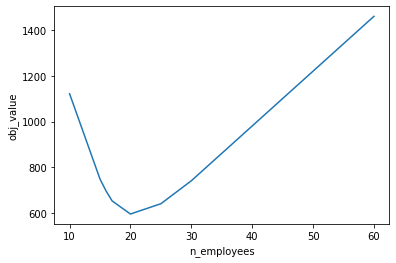

In [54]:
sns.lineplot(data=results_df.query('region == 0'), x='n_employees', y='obj_value')
plt.show()

In [55]:
# REGION RESULTS
region = 0
selected_areas = s.i.region_area_map[region]

region_results = results_df.query(f'region == {region}')

# OPTIMAL SOLUTION
optimal_n_employees = int(region_results.query(f'obj_value == {results_df["obj_value"].min()}')['n_employees'].values[0])
region_employees = {}
region_employees[region] = optimal_n_employees

i = Instance(regions=[region], areas=areas, 
    region_area_map=region_area_map, area_map=area_map, 
    period_demands=period_demands, period_couriers=period_couriers,
    region_employees=region_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
    shifts_start=shifts_start, shifts_end=shifts_end)

s = Solver(i)
s.solve()

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2080 rows, 69704 columns and 33280 nonzeros
Model fingerprint: 0x4d0c0b92
Model has 8400 quadratic constraints
Variable types: 3304 continuous, 66400 integer (66400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 385 rows and 60689 columns
Presolve time: 0.17s
Presolved: 1695 rows, 9015 columns, 26755 nonzeros
Variable types: 0 continuous, 9015 integer (8933 binary)
Found heuristic solution: objective 2611.5000000

Root relaxation: objective 5.280000e+02, 3349 iterations, 0.12 seconds (0.10 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

In [56]:
# Area Employee assignment (for each region)
area_employee_assignment = []
for e in s.employees:
    for a in areas:
        for theta in s.Theta:
            for d in s.D:
                for p in s.shifts:
                    shift = int(s.r_var[e, p, d].X)
                value = s.k_var[e, s.i.area_map[a], theta, d].X
                if value > 0.5:
                    area_employee_assignment.append([e, a, theta, d, shift])

area_employee_assignment_df = pd.DataFrame(area_employee_assignment, columns=['employee', 'area', 'period', 'day', 'shift'])

In [57]:
area_employee_assignment_df.query('employee == 0').sort_values(['day', 'period'])

,employee,area,period,day,shift
15,0,10318,2,0,1
4,0,10247,3,0,1
6,0,10247,4,0,1
8,0,10247,5,0,1
0,0,10245,0,1,0
3,0,10247,1,1,0
20,0,10365,2,1,0
13,0,10315,3,1,0
10,0,10249,2,2,1
16,0,10318,3,2,1


In [58]:
couriers_needed_ = []
for d in s.D:
    data = (
        pd.DataFrame(s.couriers_needed[:,:,d], index=areas, columns=s.Theta).reset_index()
        .rename(columns={'index': 'area'})
        #.assign(day = d)
    )

    area_day_data = (
        pd.melt(data, id_vars=['area'], value_vars=set(data.columns).difference('area'))
        .rename(columns={'variable': 'period', 'value': 'n_couriers'})
        .assign(day = d)
    )
    couriers_needed_.append(area_day_data)

couriers_needed_df = pd.concat(couriers_needed_)

# Demand
deliveries_ = []
for d in s.D:
    data = (
        pd.DataFrame(s.deliveries[:,:,d], index=areas, columns=s.Theta).reset_index()
        .rename(columns={'index': 'area'})
        #.assign(day = d)
    )

    area_day_data = (
        pd.melt(data, id_vars=['area'], value_vars=set(data.columns).difference('area'))
        .rename(columns={'variable': 'period', 'value': 'deliveries'})
        .assign(day = d)
    )
    deliveries_.append(area_day_data)

deliveries_df = pd.concat(deliveries_)

couriers_needed_df = pd.merge(couriers_needed_df, deliveries_df, on=['area', 'period', 'day'])
couriers_needed_df.head()

# areas
area_period_days_df = (
    area_employee_assignment_df
    .groupby(['area', 'period', 'day'])
    .agg({'employee': ['count', 'unique']})
    .reset_index()
)
area_period_days_df.columns = ['area', 'period', 'day', 'employee_count', 'employees_assign']
area_period_days_df

# Outsourcing
outsourcing_shifts = []
for a in areas:
    for theta in s.Theta:
        for d in s.D:
            value = s.omega_var[s.i.area_map[a],theta,d].X
            #print(f'{a} {theta} {d} : {value}')
            if value > 0.0:
                outsourcing_shifts.append([a, theta, d, value])

outsourcing_shifts_df = pd.DataFrame(outsourcing_shifts, columns=['area', 'period', 'day', 'cost_outsource'])

# Join all
whole_solution_df = (
    couriers_needed_df
    # Employees
    .merge(area_period_days_df,  on=['area', 'period', 'day'], how='left')
    # Outsource
    .merge(outsourcing_shifts_df, on=['area', 'period', 'day'], how='left')
)
# DROP AREAS NOT IN REGION!!
whole_solution_df = whole_solution_df.query(f'area.isin({selected_areas})')
whole_solution_df['employee_count'].fillna(0, inplace=True)

whole_solution_df.query('deliveries != 0').head(30)

,area,period,n_couriers,day,deliveries,employee_count,employees_assign,cost_outsource
7,10247,0,1.0,0,1.0,1.0,[9],NaN
15,10369,0,1.0,0,1.0,1.0,[5],NaN
65,10245,1,1.0,0,5.0,1.0,[9],NaN
66,10247,1,1.0,0,3.0,1.0,[4],NaN
67,10249,1,1.0,0,3.0,1.0,[19],NaN
68,10315,1,1.0,0,5.0,1.0,[5],NaN
69,10317,1,1.0,0,2.0,0.0,NaN,3.0
70,10318,1,1.0,0,2.0,0.0,NaN,3.0
71,10319,1,1.0,0,1.0,0.0,NaN,1.5
72,10365,1,1.0,0,2.0,0.0,NaN,3.0


In [59]:
employees_shifts = []
for e in s.employees:
    for p in s.shifts:
        for d in s.D:
            value = s.r_var[e, p, d].X
            if value > 0.5:
                employees_shifts.append({'employee': e, 'shift': p, 'day':d, 'value': value})

employees_shifts_df = pd.DataFrame(employees_shifts)
employees_shifts_df.head()

day_employees_shifts_df = employees_shifts_df.groupby(['day', 'shift'])['value'].sum().reset_index()
day_employees_shifts_df

,day,shift,value
0,0,0,4.0
1,0,1,13.0
2,1,0,2.0
3,1,1,15.0
4,2,0,2.0
5,2,1,16.0
6,3,0,5.0
7,3,1,12.0
8,4,0,5.0
9,4,1,12.0


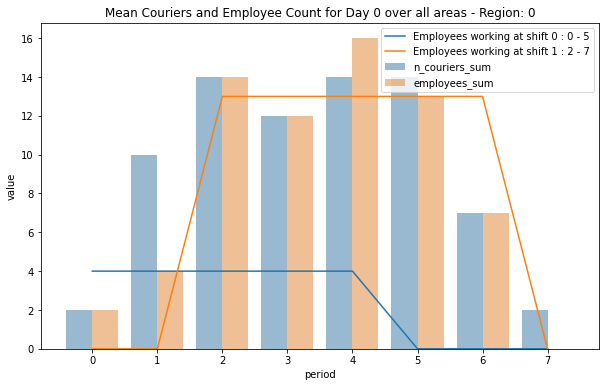

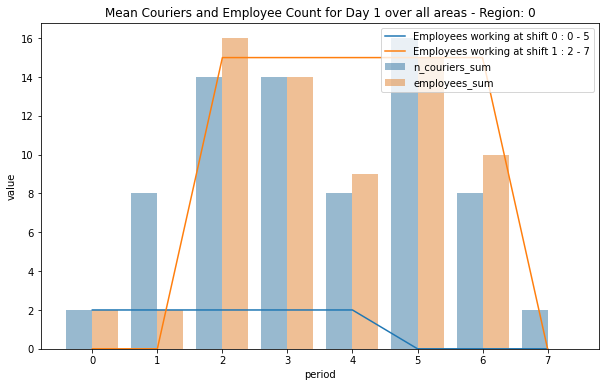

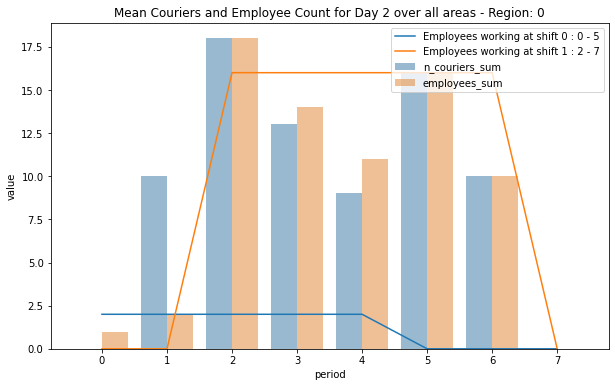

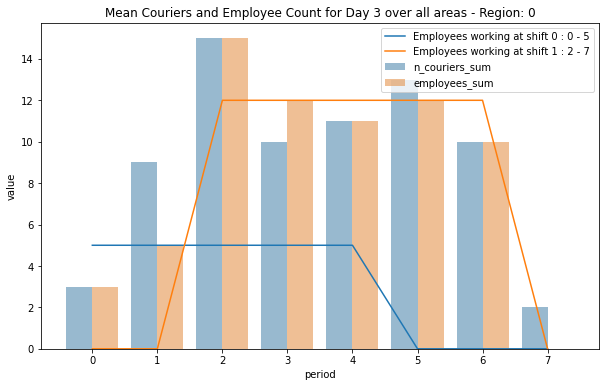

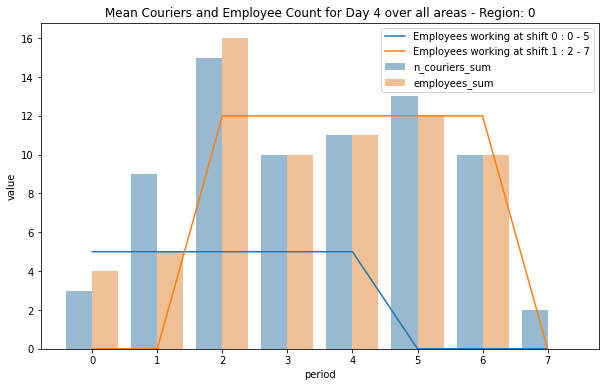

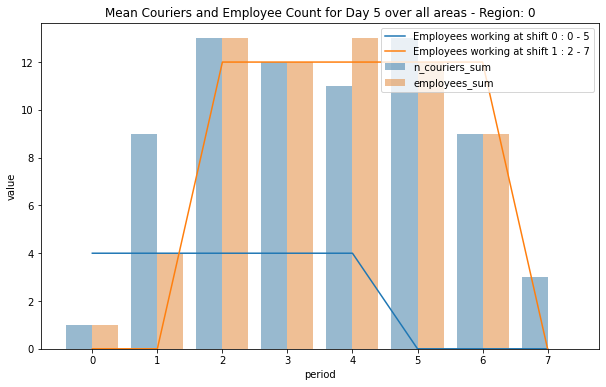

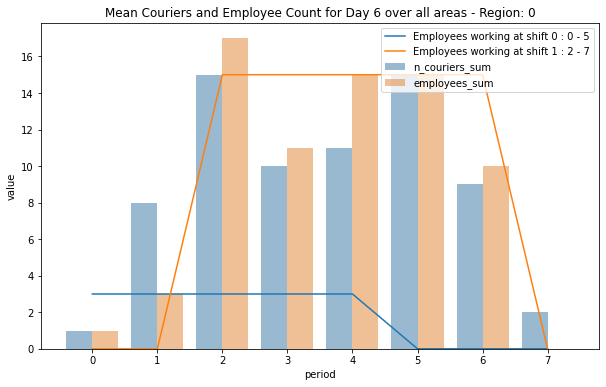

In [60]:
for d in s.D:
    _ = whole_solution_df.query(f'day == {d}').groupby('period').agg({'n_couriers': ['sum', 'mean', 'min', 'max'], 'employee_count': ['sum', 'mean', 'min', 'max']})
    _.columns = ['n_couriers_sum', 'n_couriers_mean', 'n_couriers_min', 'n_couriers_max',
                 'employees_sum', 'employees_mean', 'employees_min', 'employees_max']
    
    a = pd.melt(_.reset_index(), id_vars='period', value_vars=['n_couriers_sum', 'employees_sum'])
    plt.figure(figsize=(10, 6))

    sns.barplot(data=a, x='period', y='value', hue='variable', alpha=0.5)

    # SHIFTS
    for key, x in s.i.shifts_start[region].items():
        start = s.i.shifts_start[region][key]
        end = s.i.shifts_end[region][key]+1
        
        if int(key) in list(day_employees_shifts_df.query(f'day == {d}')['shift'].values):
            workers = day_employees_shifts_df.query(f'shift == {int(key)} & day == {d}')['value'].values[0]
            #periods_ = [x for x in range(8) if i in range(start, end)]

            sns.lineplot(x=[p for p in range(8)], y=[workers if i >= start and i < end else 0 for i in range(8)], label=f'Employees working at shift {key} : {start} - {end}')

    plt.title(f"Mean Couriers and Employee Count for Day {d} over all areas - Region: {region}")  # Adding title
    plt.legend(loc='upper right')  # Displaying legend
    
    plt.show()